In [205]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import multiprocessing as mp
import seaborn as sns
import pickle

from cvx.stat_arb.ccp import *
from cvx.stat_arb.utils import *
from cvx.stat_arb.backtest import *

sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
# Load sector_to_asset and asset_to_sector from file
with open('../data/sector_to_asset.pkl', 'rb') as f:
    sector_to_asset = pickle.load(f)
with open('../data/asset_to_sector.pkl', 'rb') as f:
    asset_to_sector = pickle.load(f)

In [256]:
# data = pd.read_csv("../data/asset_data_2000_to_2023.csv")
# data = data.drop(["TICKER", "PERMCO"], axis=1)
# prices = pd.pivot_table(data, values='PRC', index='date', columns='PERMNO', fill_value=None)
# prices.index = pd.to_datetime(prices.index, format="%Y-%m-%d")


prices = pd.read_csv("../data/prices_500_cleaned.csv", index_col=0, parse_dates=True).dropna(axis=1, how="any")
prices.columns = prices.columns.astype(int)

# Remove Berkshire Hathaway
prices = prices.drop([540], axis=1)

# Choose sector
# assets = sector_to_asset["Finance and Insurance"]
# assets = [asset for asset in assets if asset in prices.columns]
# prices = prices[assets]

prices_train = prices.loc["2017-01-01":"2017-12-31"]
prices_val = prices.loc["2018-01-01":"2018-01-31"]
prices_test = prices.loc["2018-02-01":"2018-06-30"]

prices_train_val = pd.concat([prices_train, prices_val]) # For later use

# Static (a single time period)

In [259]:
### Get list of stat arbs
seed=999
P_max = 15
stat_arb_group = construct_stat_arbs(prices_train, K=100, P_max=P_max,\
     spread_max=1, M=500, solver="ECOS", seed=seed, parallel=True)

 25%|██▌       | 25/100 [00:27<00:52,  1.43it/s]/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


In [270]:
assets = []
unique = 0
for stat_arb in stat_arb_group.stat_arbs:
    assets_temp = stat_arb.asset_names
    if assets_temp in assets:
        continue
    else:
        assets.append(assets_temp)
        unique += 1
print("Number of unique stat arbs: ", unique)

Number of unique stat arbs:  91


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


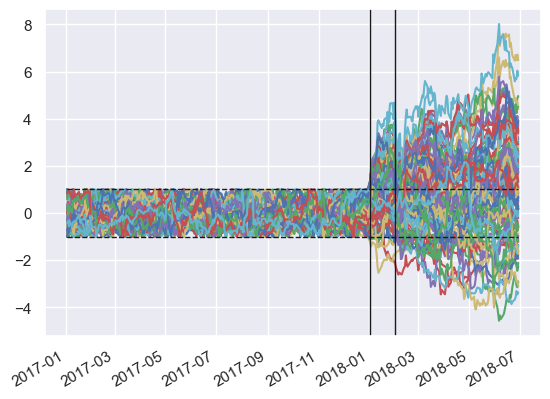

/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


In [261]:
### Plot stat arb group
plot_all_portfolios(stat_arb_group.stat_arbs, prices_train, prices_val, prices_test)
plt.gcf().autofmt_xdate();

In [262]:
lens = []
for arb in stat_arb_group.stat_arbs:
    lens.append(len(arb.asset_names))
np.mean(lens)

5.2

# Trading backtest

### Using the Portfolio class

In [264]:
cutoff_val = 1
cutoff_up_test = 1
cutoff_down_test = 1
SR_cutoff = None
profit_target=0
stat_arbs_validated = stat_arb_group.validate(prices_val,
         prices_train_val, cutoff_val, SR_cutoff, profit_target, P_max=None)   

portfolio = stat_arbs_validated.construct_portfolio(prices_test, cutoff_up_test,cutoff_down_test)

m_p = Metrics(portfolio.profit)
print("profit: ", np.round(m_p.total_profit,2))
print("SR: ", np.round(m_p.sr_profit,2))

profit:  1.97
SR:  1.85


In [265]:
returns = portfolio.nav.pct_change().dropna()
mu = returns.mean() * 252
sigma = returns.std() * np.sqrt(252)
SR = mu / sigma
SR

1.9941480433925318

In [266]:
(np.array([len(stat_arb.asset_names) for stat_arb in stat_arbs_validated.stat_arbs]) >= 4).sum()

10

/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


In [267]:
np.mean([len(stat_arb.asset_names) for stat_arb in stat_arbs_validated.stat_arbs])

4.636363636363637

In [269]:
len(stat_arbs_validated.stat_arbs)

11

/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting
Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting
Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/publicRepo/cvx_stat_arb/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver failed... resetting


In [268]:
m_p.total_profit

1.9747909806967605

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


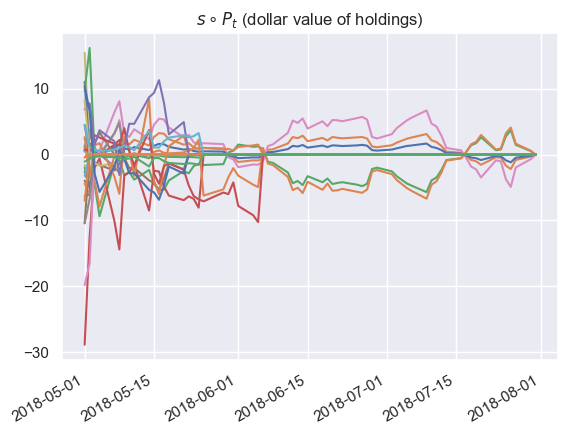

In [239]:
### Visualize portfolio holdings
holdings = portfolio.stocks * portfolio.prices
plt.plot(holdings.index, holdings);
plt.legend(holdings.columns, bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title(r"$s\circ P_t$ (dollar value of holdings)");
plt.gcf().autofmt_xdate()
plt.gca().legend().remove();

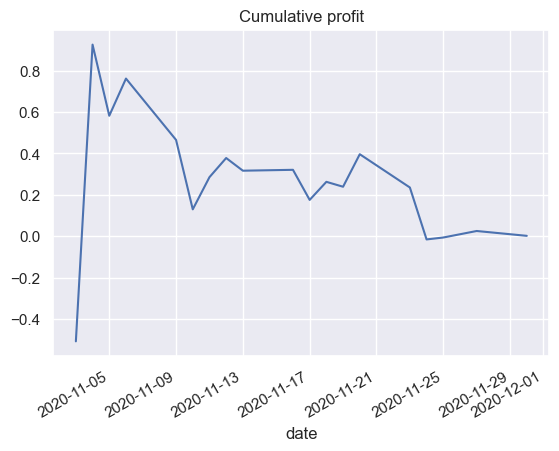

In [16]:
m_p.daily_profit.cumsum().plot(); plt.title("Cumulative profit");

Fraction of profitable stat arbs:  0.5714285714285714
Average profit of profitable stat arbs:  0.4057450478736443
Average loss of unprofitable stat arbs:  -0.28309865358137015


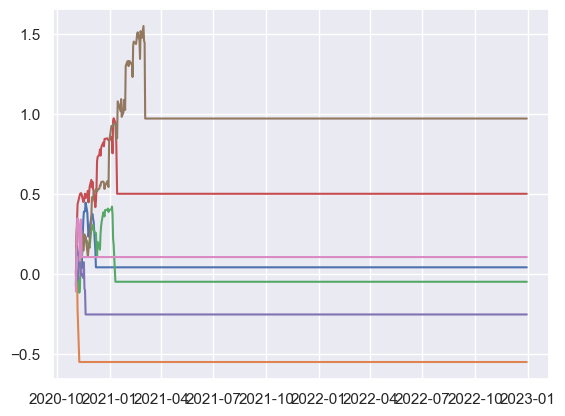

In [181]:
profitable = 0
unprofitable = 0
wins = []
losses = []
for stat_arb in stat_arbs_validated.stat_arbs:
    m = stat_arb.metrics(prices_test)
    if m is not None:
        plt.plot(m.daily_profit.cumsum())
        if m.total_profit > 0:
            profitable += 1
            wins.append(m.total_profit)
        else:
            unprofitable += 1
            losses.append(m.total_profit)


print("Fraction of profitable stat arbs: ", profitable / (profitable + unprofitable))
print("Average profit of profitable stat arbs: ", np.mean(wins))
print("Average loss of unprofitable stat arbs: ", np.mean(losses))

#### Using the StatArbGroup class

In [17]:
stat_arb_group = StatArbGroup(stat_arbs_validated.stat_arbs)

In [20]:
m_sg   = stat_arb_group.metrics(prices_test, cutoff=1.05)
print("profit: ", np.round(m_sg.total_profit, 2))
print("SR: ", np.round(m_sg.sr_profit,2))

profit:  6.26
SR:  4.1


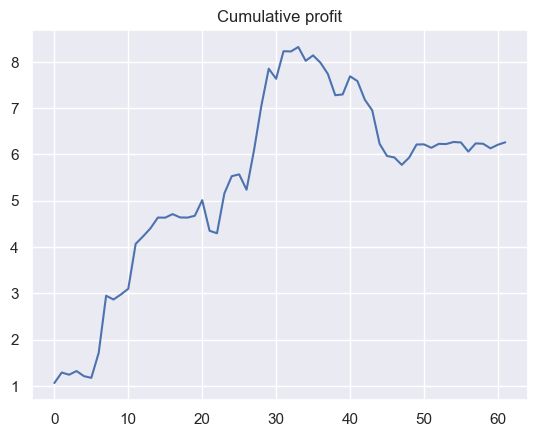

In [21]:
plt.plot(m_sg.daily_profit.cumsum().values); plt.title("Cumulative profit");